In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
from sklearn.model_selection import cross_val_score, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

### **Loading The Dataset**

In [2]:
df = pd.read_csv('Data/train.csv', delimiter=',')

In [3]:
pd.set_option('display.max_rows', None)

In [4]:
df.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


### **Data Cleaning**

In [5]:
shape_before = df.shape
print("Original Shape: ", shape_before)

Original Shape:  (891, 12)


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [7]:
df.corr()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.000000,-0.005007,-0.035144,0.036847,-0.057527,-0.001652,0.012658
Survived,-0.005007,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307
Pclass,-0.035144,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500
Age,0.036847,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.057527,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651
Parch,-0.001652,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225
Fare,0.012658,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000


### Checking for Null values

In [8]:
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

> Features **Age**, **Cabin** and **Embarked** have missing values. But since, specially for **Cabin** and **Age**, this datapoints are large in number, so it is a good idea to first see their impact on passangers' survival before deciding what to do about them.

### Handling missing Values for **Age**, **Cabin** and **Embarked** Features

The features **Age**, **Cabin** and **Embarked** are subject of interest. But since dropping the missing values significantly affects the size of the dataset for features **Age** and **Cabin**, another option should be explored. 

#### **Age**

The missing values on the **Age** feature is filled with the median value of the whole set. Choosing the mideian value is better for imputation in the case of outliers.

In [9]:
age_list = list((df["Age"]).dropna())
age_median = np.median(age_list)

In [10]:
print("Median age for the passengers is: ", age_median)

Median age for the passengers is:  28.0


In [11]:
print("\nBefore filling the missing values:")
df.Age[:6]


Before filling the missing values:


0    22.0
1    38.0
2    26.0
3    35.0
4    35.0
5     NaN
Name: Age, dtype: float64

In [12]:
df["Age"] = df["Age"].fillna(age_median)

In [13]:
print("\nAfter filling the missing values:")
df.Age[:6]


After filling the missing values:


0    22.0
1    38.0
2    26.0
3    35.0
4    35.0
5    28.0
Name: Age, dtype: float64

#### **Cabin**

To understand the extent to which the missing values on the **Cabin** feature impact passengers' survival, I will replace those missing values with **0**. Similarly I will replace the datapoints with values present with **1** to better assess the dynamic at play.

In [14]:
print("\nBefore filling the missing values:")
df.Cabin[:5]


Before filling the missing values:


0     NaN
1     C85
2     NaN
3    C123
4     NaN
Name: Cabin, dtype: object

In [15]:
df["Cabin"] = df["Cabin"].fillna(0)
df["Cabin"] = df.Cabin.apply(lambda x: 1 if x != 0 else x)

In [16]:
print("\nAfter filling the missing values:")
df.Cabin[:5]


After filling the missing values:


0    0
1    1
2    0
3    1
4    0
Name: Cabin, dtype: int64

#### Plotting for Cabin versus Survival

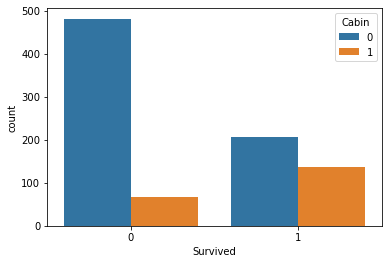

In [17]:
sns.countplot(data=df, x="Survived", hue="Cabin")
plt.show()

It can be derived from the plot that datapoints with missing values for the **Cabin** feature have major contributions to the target feature. Although some of the datapoints contribute to the death of passangers, the majority contribute to those who survived. Therefore, considering a value of **0** for the missing values in this feature is an acceptable risk.

#### **Embarked**

In the case of the feature **Embarked**, there are only two missing values. Therefore, removing the datapoints associated with those two missing values is the next logical step.

In [18]:
df = df.dropna()

In [19]:
df.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,0,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,1,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,0,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,1,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,0,S
5,6,0,3,"Moran, Mr. James",male,28.0,0,0,330877,8.4583,0,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,1,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,0,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,0,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,0,C


In [20]:
shape_after = df.shape
shape_diff = shape_before[0] - shape_after[0]

In [21]:
print("Original Shape: ", shape_before, "\nShape after droping null values: ", shape_after)

Original Shape:  (891, 12) 
Shape after droping null values:  (889, 12)


In [22]:
print("Number of datapoints removed: ", shape_diff)

Number of datapoints removed:  2


> The data requires additional cleaning as the features are yet to be represented numerically.